In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Building a Model to Predict the Quality of Red Wine 

Trushaan Bundhoo, Jennifer Chu, Mantra Patel, Maira Zaidi

Introduction 

Winemaking is a large global industry, with over 330 billion USD worth of wine sold in 2020. Cheap wine is around 15 USD / bottle, with more expensive ones fetching 500 USD+. Wine price is dictated partly by its quality, which is linked to factors like sugar content, acidity, alcohol content, and more. Since these dictate the flavor of red wine, we would like to ask: can citric acid levels, alcohol content, and sugar be used to predict the quality of wine?

In [2]:
red<- read_csv2("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv") 
red

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): volatile acidity, citric acid, chlorides, density, sulphates
dbl (2): total sulfur dioxide, quality

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
74,0.7,0,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.88,0,26,0.098,25,67,0.9968,32,0.68,98,5
78,0.76,0.04,23,0.092,15,54,0.997,326,0.65,98,5
112,0.28,0.56,19,0.075,17,60,0.998,316,0.58,98,6
74,0.7,0,19,0.076,11,34,0.9978,351,0.56,94,5
74,0.66,0,18,0.075,13,40,0.9978,351,0.56,94,5
79,0.6,0.06,16,0.069,15,59,0.9964,33,0.46,94,5
73,0.65,0,12,0.065,15,21,0.9946,339,0.47,10,7
78,0.58,0.02,2,0.073,9,18,0.9968,336,0.57,95,7


Preliminatory Data Analysis 

For this model, we will be focusing on how citric acid, residual sugar, and alcohol content affect the rating of red wine. Below, we will select them and create our training and testing sets. 

In [3]:
red_data <- red |>
            mutate(quality = as_factor(quality))
colnames(red_data) <- make.names(colnames(red_data))

red_data_scaled<-red_data |>
                mutate(citric.acid=as.numeric(citric.acid)) |>
                mutate(scaled_citric_acid=scale(citric.acid,center=TRUE),
                        scaled_residual_sugar=scale(residual.sugar,center=TRUE),
                        scaled_alcohol=scale(alcohol,center=TRUE))

red_split<-initial_split(red_data_scaled, prop=0.75, strata=quality)
red_train<-training(red_split) 
red_test<-testing(red_split) 

red_train_set<-red_train |>
                select(c(citric.acid,residual.sugar,alcohol,scaled_citric_acid,scaled_residual_sugar,scaled_alcohol,quality))
red_test_set<-red_test |>
                select(c(citric.acid,residual.sugar,alcohol,scaled_citric_acid,scaled_residual_sugar,scaled_alcohol,quality))
red_train_set




citric.acid,residual.sugar,alcohol,scaled_citric_acid,scaled_residual_sugar,scaled_alcohol,quality
<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
0.00,19,94,-1.39103710,-0.18264984,-0.04317968,5
0.00,26,98,-1.39103710,-0.01701753,-0.04317968,5
0.00,19,94,-1.39103710,-0.18264984,-0.04317968,5
0.06,16,94,-1.08303069,-0.25363512,-0.04317968,5
0.36,61,105,0.45700139,0.81114405,-0.04317968,5
0.36,61,105,0.45700139,0.81114405,-0.04317968,5
0.00,16,99,-1.39103710,-0.25363512,-0.04317968,5
0.29,16,91,0.09766057,-0.25363512,-0.04317968,5
0.18,38,92,-0.46701786,0.26692358,-0.04317968,5


In [4]:
counts<-red_train_set |>
        group_by(quality) |>
        summarize(n=n())
counts

counts_sugar<-red_train_set |>
        group_by(residual.sugar, quality) |>
        summarize(n=n())
counts_sugar

quality,n
<fct>,<int>
3,8
4,36
5,512
6,479
7,149
8,14


`summarise()` has grouped output by 'residual.sugar'. You can override using
the `.groups` argument.


residual.sugar,quality,n
<dbl>,<fct>,<int>
2,4,4
2,5,54
2,6,49
2,7,11
2,8,1
3,5,7
3,6,8
4,5,2
4,6,5


The two tables generated from our training set provide insight about the wrangled data. The "counts" table provides the number of red wines that were given a particular rating, with most being rated a 5/8. The "counts_sugar" table is longer and shows the ratings given based on their residual sugar content. We could potentially do the same with citric acid or alcohol content, but the wider value range would lengthen the table even more. Instead, plots help us better visualize any relationships between our 3 variables and the quality rating.

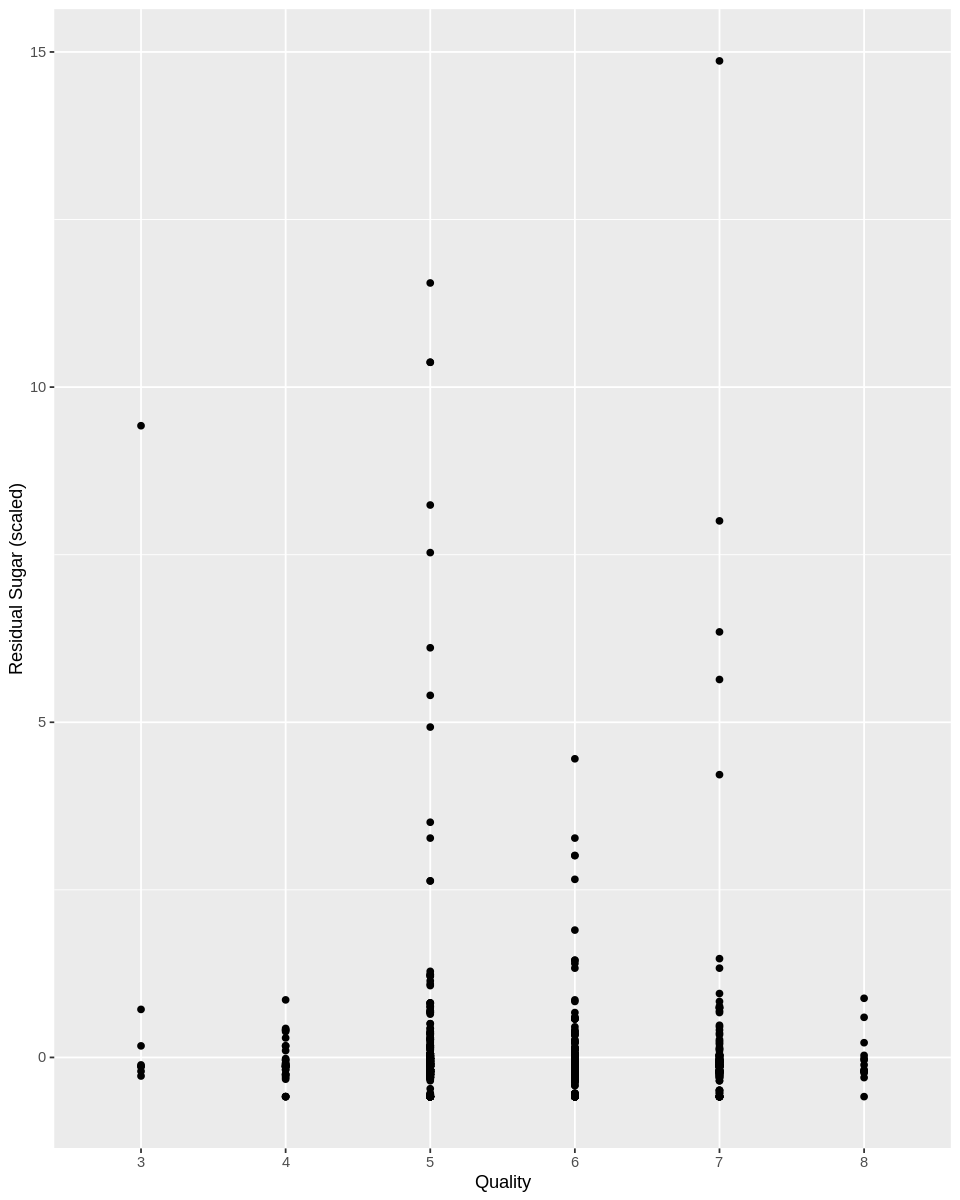

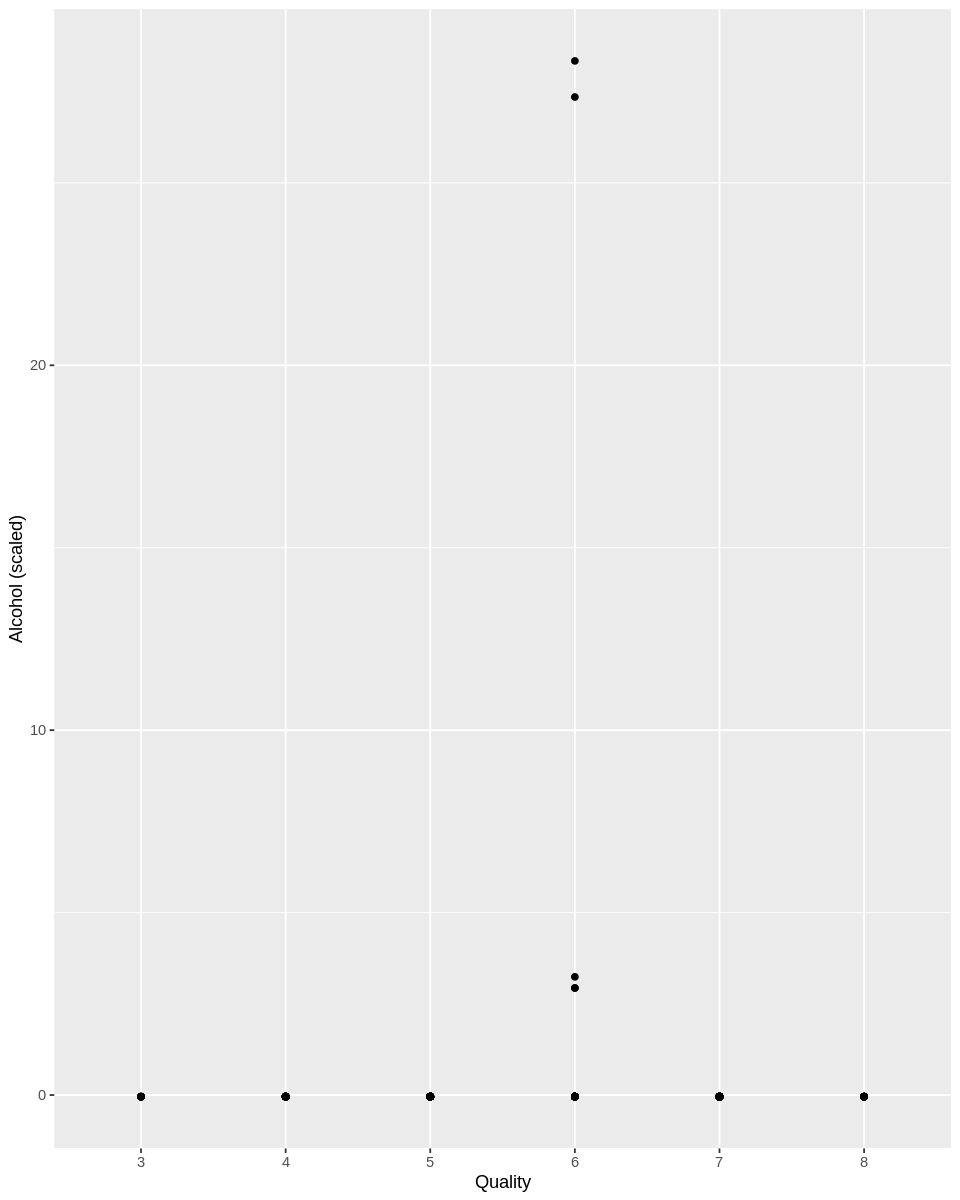

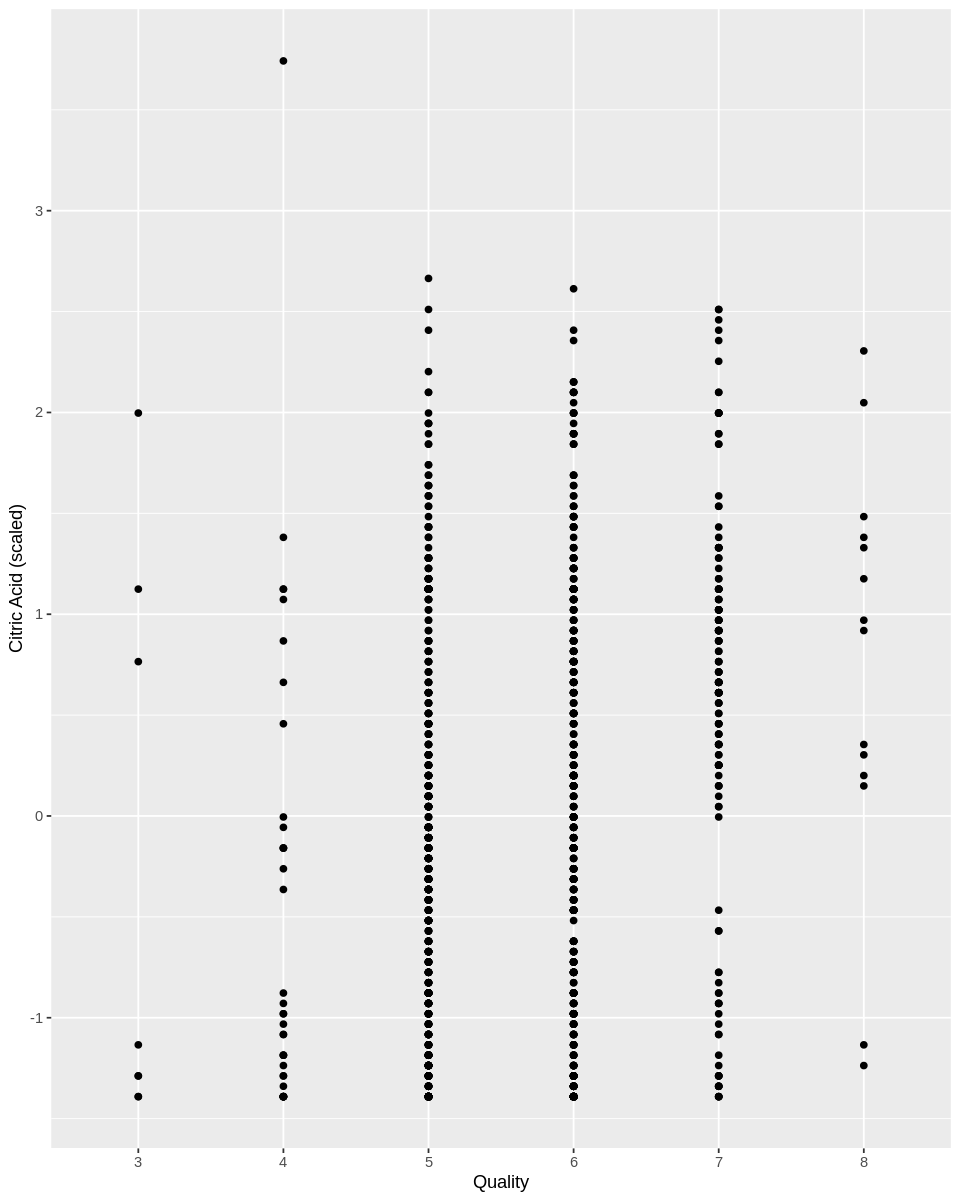

In [5]:
options(repr.plot.width = 8, repr.plot.height = 10)
sugar_plot <- ggplot(red_train_set, aes(x= quality, y=scaled_residual_sugar)) + geom_point() +xlab("Quality") + ylab("Residual Sugar (scaled)")
alcohol_plot <- ggplot(red_train_set, aes(x= quality, y=scaled_alcohol)) + geom_point() +xlab("Quality") + ylab("Alcohol (scaled)")
citric_acid_plot <- ggplot(red_train_set, aes(x= quality, y=scaled_citric_acid)) + geom_point() +xlab("Quality") + ylab("Citric Acid (scaled)")
sugar_plot
alcohol_plot
citric_acid_plot

The above plots reveal many things to us:

1 - The sugar plot shows that most of the wines have a sugar content between 0 and 100, regardless of their quality rating.

2 -  The alcohol plot isn’t much help when it comes to finding relationships, due to the wide range in alcohol content found within the wines.

3 - The citric acid plot shows that for wines within a given rating, there is a wide range of possible citric acid values.


Methods

Given the importance of acidity, sugar, and alcohol in winemaking, we will use values from these columns to build a predictive model that determines the quality rating for a given red wine. We plan to use a K-nn classification model, using nearest neighbors for citric acid, alcohol, and residual sugar to predict the wine quality. The K-nn model will be tested and tuned to find the best K to give the best prediction. The model will then be applied to the testing set, to see if our predictive model holds true for unseen data.

Expected Outcomes

Based on what we saw from the exploratory tables and visualizations, we hope that the model we build will be able to accurately predict wine quality. Human taste is ultimately the key aspect of determining whether a wine is high quality, but if quality is predicted by chemical properties alone, it could lead to breakthroughs in the winemaking industry. If successful, such a predictive model can have large implications in the industry, as the information could be used by winemakers to understand how they can produce higher quality wine, and rake in more profit. This could lead to the integration of modern chemical techniques and engineering with winemaking to revolutionize a craft that has been around for thousands of years.


Analysis 

We will now begin the construction of our predictive model. We will begine by creating a recipe, stating our predictors for use in the algorithm. To maximize accuracy of our classifier, we will be performing a 5-fold cross validation, and tuning our model to find the K value with the highest accuracy. This is done in the cell below.

In [28]:
red_recipe<-recipe(quality~residual.sugar +alcohol+citric.acid, data=red_train) |> step_scale(all_predictors()) |> step_center(all_predictors())
red_vfold<-vfold_cv(red_train, v=5, strata=quality)
knn_tune<-nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
                             set_engine("kknn") |>
                             set_mode("classification")
knn_tune 
knn_results<-workflow() |>
            add_recipe(red_recipe) |>
            add_model(knn_tune) |>
            tune_grid(resamples=red_vfold, grid=10) |>
            collect_metrics()
knn_results



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4907418,5,0.025454352,Preprocessor1_Model01
2,roc_auc,hand_till,0.5540987,5,0.006557972,Preprocessor1_Model01
3,accuracy,multiclass,0.4739983,5,0.016158968,Preprocessor1_Model02
3,roc_auc,hand_till,0.5555444,5,0.007848035,Preprocessor1_Model02
5,accuracy,multiclass,0.4581472,5,0.016307123,Preprocessor1_Model03
5,roc_auc,hand_till,0.5623964,5,0.021306451,Preprocessor1_Model03
6,accuracy,multiclass,0.4707138,5,0.014784505,Preprocessor1_Model04
6,roc_auc,hand_till,0.5736766,5,0.018586508,Preprocessor1_Model04
8,accuracy,multiclass,0.4582484,5,0.004038087,Preprocessor1_Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4265406,5,0.005538636,Preprocessor1_Model1
4,accuracy,multiclass,0.4281863,5,0.006729269,Preprocessor1_Model2
6,accuracy,multiclass,0.4306933,5,0.009050661,Preprocessor1_Model3
7,accuracy,multiclass,0.4323669,5,0.007890005,Preprocessor1_Model4
8,accuracy,multiclass,0.4298529,5,0.009143307,Preprocessor1_Model5
10,accuracy,multiclass,0.4198319,5,0.007498187,Preprocessor1_Model6
11,accuracy,multiclass,0.4173179,5,0.009840192,Preprocessor1_Model7
13,accuracy,multiclass,0.4206583,5,0.008963483,Preprocessor1_Model8
14,accuracy,multiclass,0.4206513,5,0.009820304,Preprocessor1_Model9


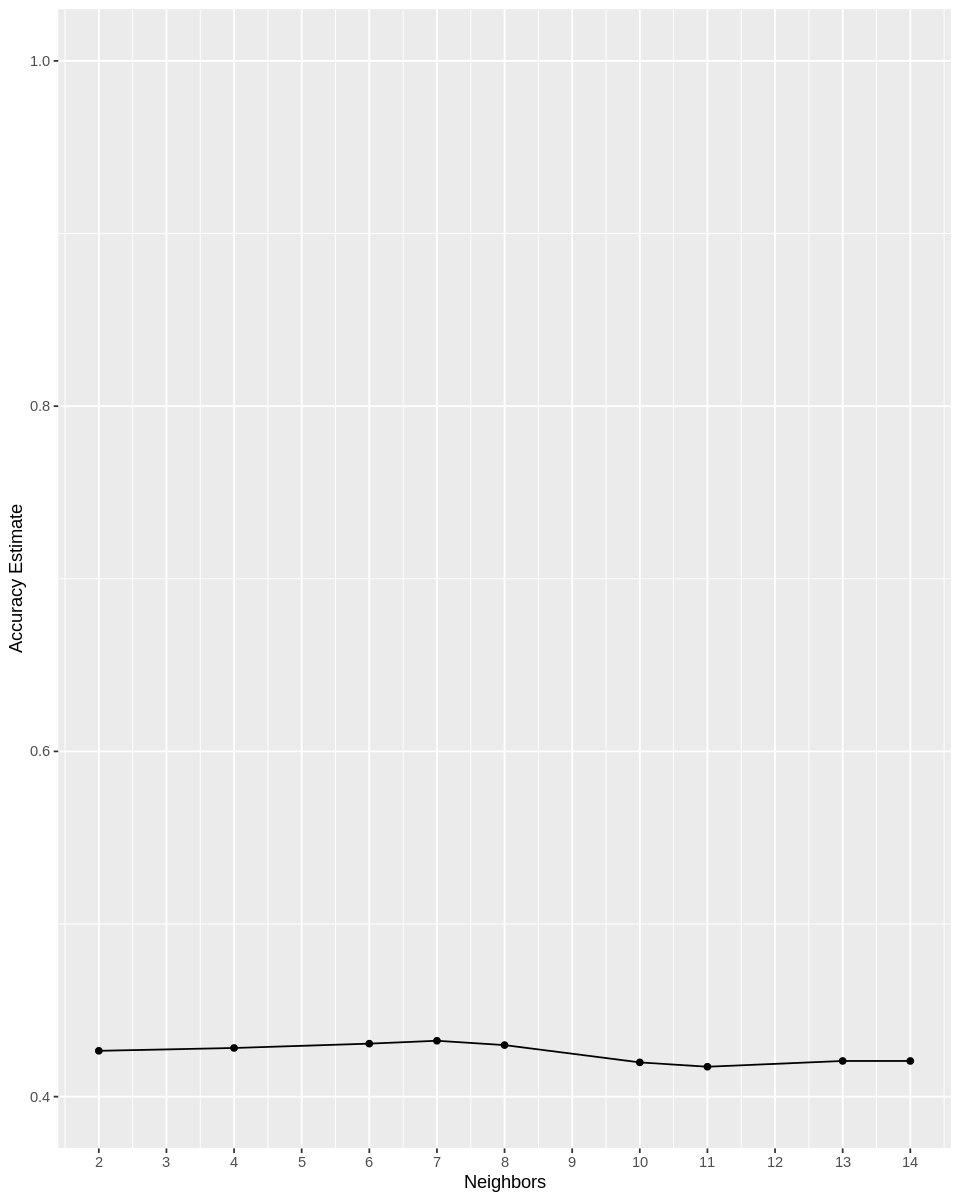

In [27]:
accuracies<-knn_results |>
            filter(.metric=='accuracy')
accuracies 

cross_val_plot<-ggplot(accuracies, aes(x=neighbors, y=mean))+
                    geom_point() +
                    geom_line() +
                    labs(x='Neighbors', y='Accuracy Estimate') +
                    scale_x_continuous(breaks=seq(0,14,by=1)) +
                    scale_y_continuous(limits=c(0.4,1.0))
cross_val_plot
